In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.metrics as mt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm 
from statsmodels.formula.api import ols
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [ ]:
#Setup graphics
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10,8)
HeatMapParams = {'annot':True, 'cmap': 'coolwarm','linewidths':1}

#Loading data

In [ ]:
df = pd.read_csv('loan_sanction.csv')

In [ ]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


<font size = 6><strong> Steps to follow:  </strong></font>
<li> Find correlations
<li> Decide action base on feature
<li> Drop selected columns
<li> Looking for null values
<li> Encode suitable features
<li> Build model
<hr>

# Columns to drop

In order to decide which columns to drop, let's try to see the correlation between categorical features and Loan_Status (label)

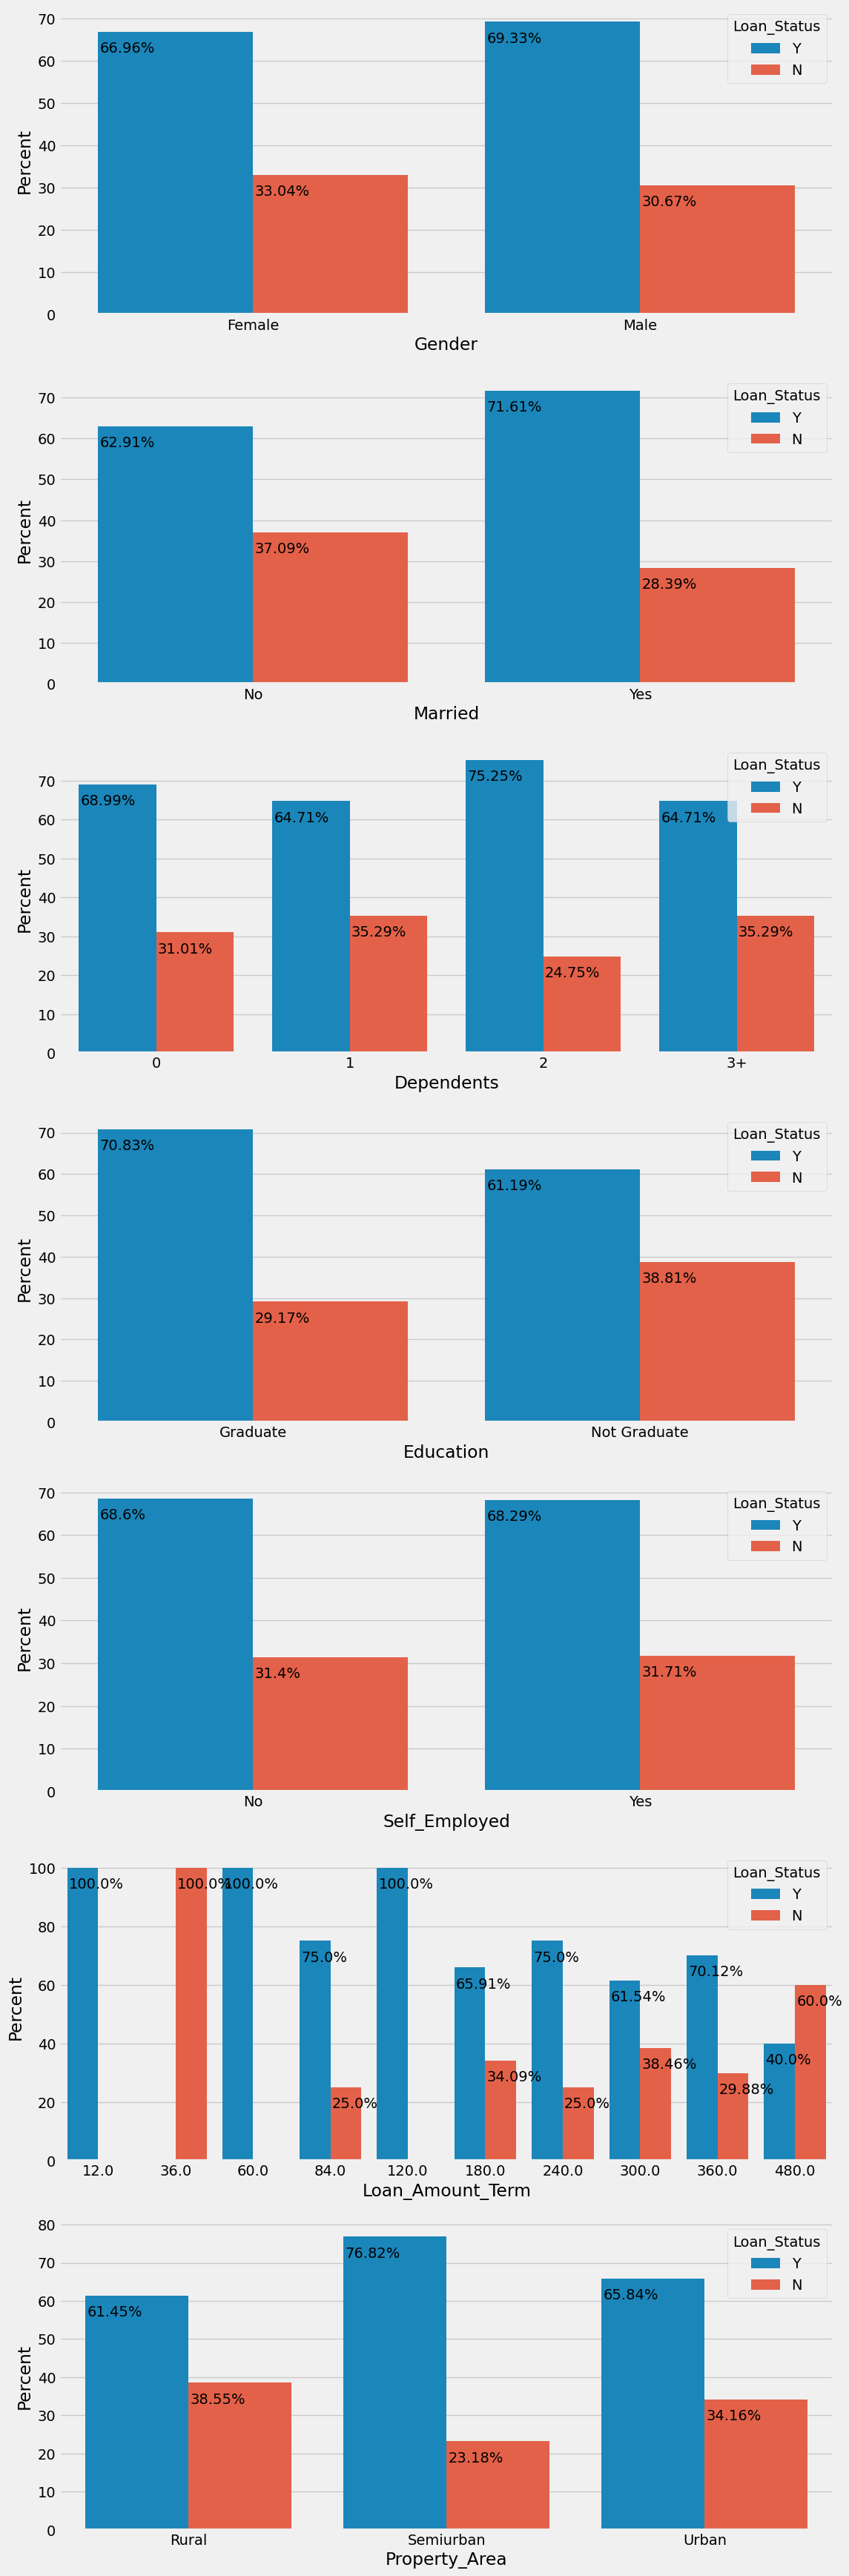

In [ ]:
columns_to_plot = ['Gender', 'Married','Dependents','Education','Self_Employed','Loan_Amount_Term', 'Property_Area']
num_of_plots = len(columns_to_plot)

fig, ax = plt.subplots(num_of_plots,1,figsize=(12,(num_of_plots*6)))

for i, column in enumerate(columns_to_plot):
  df_temp = df.groupby(column)['Loan_Status'].value_counts(normalize=True)
  df_temp = df_temp.mul(100)
  df_temp = df_temp.rename('Percent').reset_index()
  graphic = sns.barplot(data=df_temp,x=column,y='Percent',hue='Loan_Status', ax=ax[i])

  for p in graphic.patches:
    text = str(p.get_height().round(2)) + '%'
    text_x = p.get_x()
    text_y = p.get_height()
    ax[i].annotate(text,xy=(text_x, text_y), xycoords='data',xytext=(1.5,-20), textcoords='offset points')
  

The graphics above give us a hint about the correlation between the categorical features and the label.
The features `Gender` and `Self_Employed` appears to have no influence on label. 
Analysing the feature `Loan_Amount_Term` (in mounths), we come to the conclusion that there are not enough data, some values reach 100% (Yes or No), taking this fact in consideration this coloumn will be droped.
To confirm those assumptions, let's take the ANOVA test to see if there is any difference in the outcome. The null hipotesys is **"There is no difference"**, so, if we get **P_value > 0.05**, the null hipotesis cannot be discarted.

In [ ]:
columns_to_verify = ['Gender','Married', 'Dependents','Education','Self_Employed', 'Property_Area']
num_of_features = len(columns_to_plot)

#In order to apply the linear model (ols) the target cannot be string type
df['Loan_Status'] = df['Loan_Status'].apply(lambda x: 1 if x == 'Y' else 0)

for column in columns_to_verify: 
  model = ols(f'Loan_Status ~ {column}', data=df).fit()
  results = sm.stats.anova_lm(model)
  print(f'Results for {column}\n{results}', end='\n'*2+'=-'*25+'\n'*2)

Results for Gender
             df      sum_sq   mean_sq        F    PR(>F)
Gender      1.0    0.050792  0.050792  0.23628  0.627084
Residual  599.0  128.764516  0.214966      NaN       NaN

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

Results for Married
             df      sum_sq   mean_sq         F    PR(>F)
Married     1.0    1.049505  1.049505  4.893318  0.027331
Residual  609.0  130.616616  0.214477       NaN       NaN

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

Results for Dependents
               df      sum_sq   mean_sq         F    PR(>F)
Dependents    3.0    0.676189  0.225396  1.051293  0.369337
Residual    595.0  127.567550  0.214399       NaN       NaN

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

Results for Education
              df      sum_sq   mean_sq         F    PR(>F)
Education    1.0    0.973350  0.973350  4.547685  0.033361
Residual   612.0  130.987562  0.214032       NaN       NaN

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

Re

The results above confirm the previous assumptions. We can also drop the `Dependents` column.

In [ ]:
df.drop(['Loan_ID','Gender','Dependents','Self_Employed','Loan_Amount_Term'], axis=1, inplace=True)

In [ ]:
df.head()

,Married,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Property_Area,Loan_Status
0,No,Graduate,5849,0.0,NaN,1.0,Urban,1
1,Yes,Graduate,4583,1508.0,128.0,1.0,Rural,0
2,Yes,Graduate,3000,0.0,66.0,1.0,Urban,1
3,Yes,Not Graduate,2583,2358.0,120.0,1.0,Urban,1
4,No,Graduate,6000,0.0,141.0,1.0,Urban,1


Let's see the correlation between numeric features and the label to decide which remaining columns to drop.  
In order to find de correlation we will drop **NaN** values but we still leave it in the dataframe. We'll deal with null values later on.

In [ ]:
numeric_columns = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Credit_History','Loan_Status']

correlation = df[numeric_columns].dropna().corr()
fig, ax = plt.subplots(1,1,figsize=(10,8))

sns.heatmap(correlation, ax=ax, **HeatMapParams)

The only meaningful correlation occurs for `Credit_History`.

In [ ]:
df.drop(['ApplicantIncome','CoapplicantIncome','LoanAmount'], axis=1,inplace=True)

In [ ]:
df.head()

,Married,Education,Credit_History,Property_Area,Loan_Status
0,No,Graduate,1.0,Urban,1
1,Yes,Graduate,1.0,Rural,0
2,Yes,Graduate,1.0,Urban,1
3,Yes,Not Graduate,1.0,Urban,1
4,No,Graduate,1.0,Urban,1


# Null Values

In [ ]:
df.isnull().sum()

Married            3
Education          0
Credit_History    50
Property_Area      0
Loan_Status        0
dtype: int64

<BarContainer object of 2 artists>

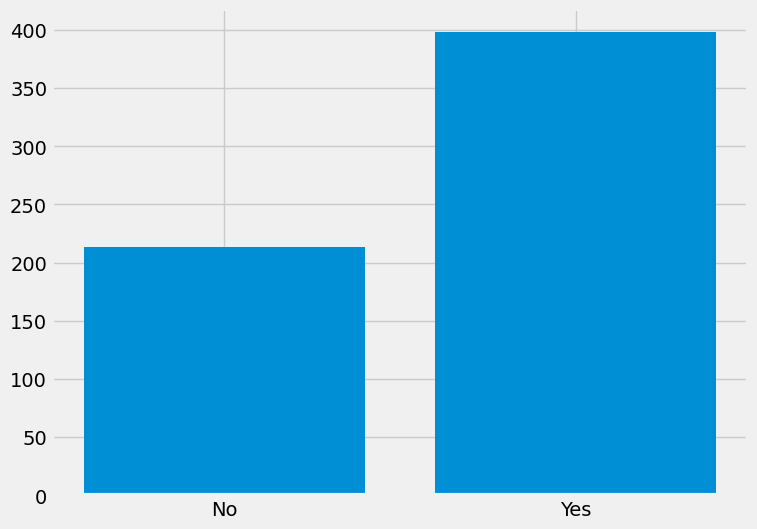

In [ ]:
married_unique = np.unique(df.Married.dropna(),return_counts=True)
plt.figure(figsize=(8,6))
plt.bar(married_unique[0], married_unique[1])

There are null values in the features `Married` and `Credit_History`.
- Married: There are only 3 missing values, so, let's just fill with the modal value (Yes).
- Credit_History: This feature is highly correlated with the label and there are too many missing values (in %). In this case let's delete those observations, otherwise the dataset can be biased.

> obs: I've try to fill the Credit_History's null values with:
> - **Yes** The modal value
> - **No**, since *No* means no information
> - **Both** values based on `Education` features. If the education level is  Graduated there are a slightly high probability that de Credit_History is Yes (graphics bellow).
> In all those cases the results were worse, leading to poor precision and recall.

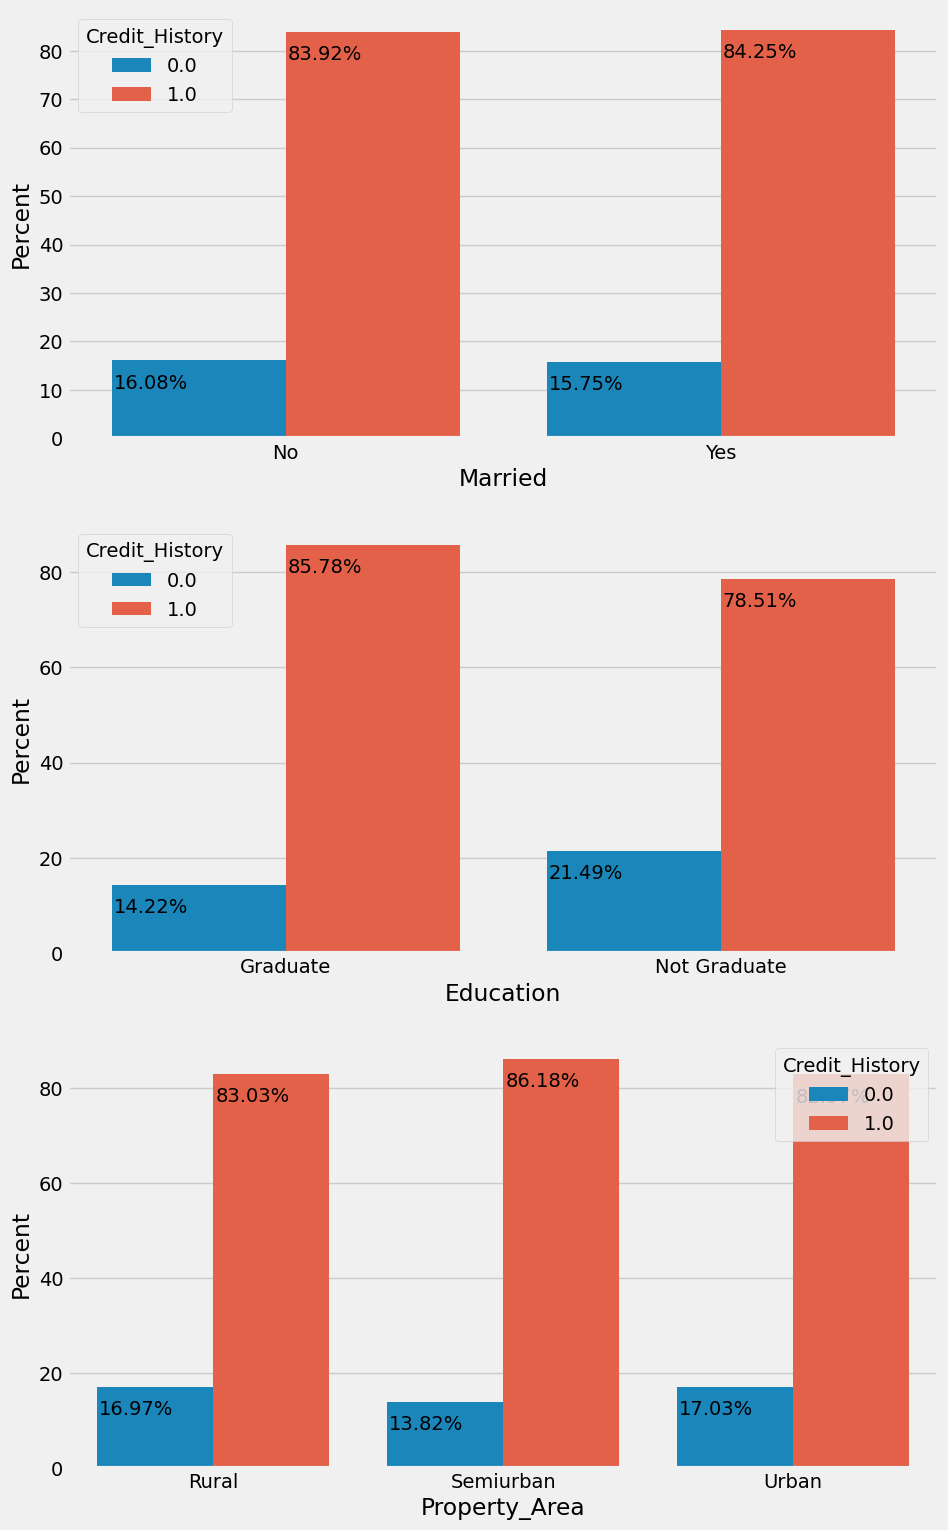

In [ ]:
columns_to_plot = ['Married','Education','Property_Area']
num_of_plots = len(columns_to_plot)

fig, ax = plt.subplots(num_of_plots,1,figsize=(10,(num_of_plots*6)))

for i, column in enumerate(columns_to_plot):
  df_temp = df.groupby(column)['Credit_History'].value_counts(normalize=True)
  df_temp = df_temp.mul(100)
  df_temp = df_temp.rename('Percent').reset_index()
  graphic = sns.barplot(data=df_temp,x=column,y='Percent',hue='Credit_History', ax=ax[i])

  for p in graphic.patches:
    text = str(p.get_height().round(2)) + '%'
    text_x = p.get_x()
    text_y = p.get_height()
    ax[i].annotate(text,xy=(text_x, text_y), xycoords='data',xytext=(1.5,-20), textcoords='offset points')

In [ ]:
df.Married.fillna('Yes', inplace=True)
df.dropna(axis=0, inplace=True)

# PreProcessing data

In [ ]:
df.head()

,Married,Education,Credit_History,Property_Area,Loan_Status
0,No,Graduate,1.0,Urban,1
1,Yes,Graduate,1.0,Rural,0
2,Yes,Graduate,1.0,Urban,1
3,Yes,Not Graduate,1.0,Urban,1
4,No,Graduate,1.0,Urban,1


Now let's change categorical features to numeric

In [ ]:
columns_to_encode = ['Married', 'Education','Property_Area']
#LabelEncoder for each column
label_enconders = {col:LabelEncoder() for col in columns_to_encode}

#Encondes the df columns
for col in columns_to_encode:
  df[col] = label_enconders[col].fit_transform(df[col])

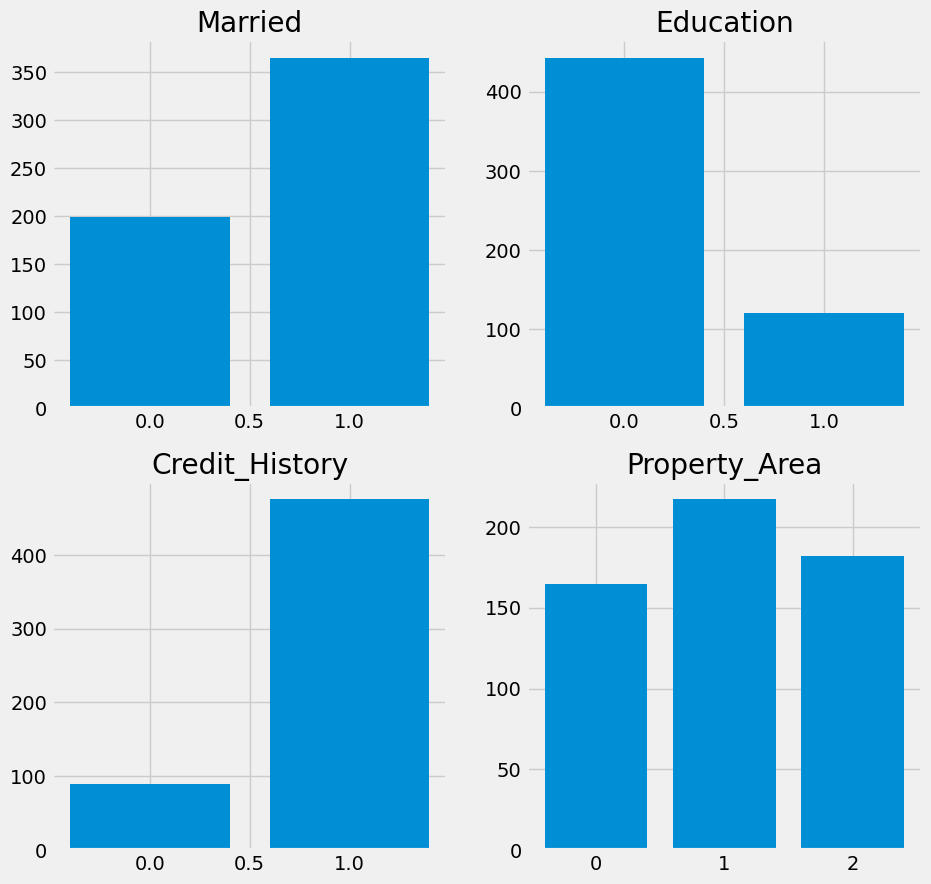

In [ ]:
rows = 2
cols = 2
columns_to_plot = ['Married', 'Education','Credit_History','Property_Area']
plt.figure(figsize=(10,10))
for i,column in enumerate(columns_to_plot):
  counts = np.unique(df[column],return_counts=True)
  plt.subplot(rows,cols,i+1)
  plt.bar(counts[0],counts[1])
  plt.title(f'{column}')

## Train/Test Split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size=0.3)

In [ ]:
(x_train.shape, y_train.shape)

((394, 4), (394,))

In [ ]:
unique = np.unique(y_train, return_counts=True)
for label, counts in zip(unique[0], unique[1]):
  print(f'Label: {label}, Counts {counts}')

Label: 0, Counts 112
Label: 1, Counts 282


Due to imbalance label, let's upsample the training set.

In [ ]:
smote = SMOTE(sampling_strategy= 'all')
x_train, y_train = smote.fit_resample(x_train, y_train)

In [ ]:
unique = np.unique(y_train, return_counts=True)
for label, counts in zip(unique[0], unique[1]):
  print(f'Label: {label}, Counts {counts}')

Label: 0, Counts 282
Label: 1, Counts 282


Let's just rescale the features and get rid of the zeros

In [ ]:
train_scaler = StandardScaler()
test_scaler = StandardScaler()
x_train = train_scaler.fit_transform(x_train)
x_test = train_scaler.fit_transform(x_test)

#Model

## Class and parameters

In [ ]:
class CustomDataSet(Dataset):
  def __init__(self, x, y):
    super().__init__()
    self.x = x
    self.y = y

  def __getitem__(self, index):
    return self.x[index], self.y[index]
  
  def __len__(self):
    return len(self.x)
    

In [ ]:
class Model(nn.Module):
  
  def __init__(self,hidden_size=50):
    super().__init__()
    self.hidden_size = hidden_size
    self.input_layer = nn.Linear(in_features=4, out_features=self.hidden_size)
    self.hidden_layer = nn.Linear(self.hidden_size,self.hidden_size)
    self.ouput_layer = nn.Linear(self.hidden_size,1)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()


  def forward(self,x):
    out = self.input_layer(x)
    out = self.relu(out)

    out = self.hidden_layer(out)
    out = self.relu(out)

    out = self.ouput_layer(out)
    out = self.sigmoid(out)

    return out

In [ ]:
#Constants
EPOCHS = 20
BATCH_SIZE = 50
LEARNING_RATE = 0.01
LR_DECAY_STEP = 5
LR_DECAY_RATE = 0.8

## Dataset in batches

In [ ]:
x_train_tensor = torch.tensor(x_train.astype(float), requires_grad=True)
y_train_tensor = torch.tensor(y_train.values.astype(float), requires_grad=True)
x_test_tensor = torch.tensor(x_test.astype(float))
y_test_tensor = torch.tensor(y_test.values.astype(float))

In [ ]:
#Target must have shape (n,1)
y_train_tensor = y_train_tensor.unsqueeze(1)
y_test_tensor = y_test_tensor.unsqueeze(1)

y_train_tensor.shape, y_test_tensor.shape

(torch.Size([564, 1]), torch.Size([170, 1]))

In [ ]:
dataset = CustomDataSet(x_train_tensor, y_train_tensor)
dataset_test = CustomDataSet(x_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=dataset_test, batch_size=BATCH_SIZE)

In [ ]:
model = Model()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE,betas=(0.90,0.99))
lr_decay = torch.optim.lr_scheduler.StepLR(optimizer,step_size=LR_DECAY_STEP,gamma=LR_DECAY_RATE)

## Training / Testing

In [ ]:
complete_predictions = torch.Tensor()
complete_ground_truth = torch.Tensor()

model.train()
for epoch in range(EPOCHS):
  interaction = 0
  correct = 0
  interaction_loss = 0  
  

  for features, ground_truth in train_loader:
    features = features.float()
    ground_truth = ground_truth.float()

    outputs = model.forward(features)
    loss = criterion(outputs,ground_truth)
    interaction_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lr_decay.step()
    prediction = (outputs>0.5).float()
    
    correct += (prediction == ground_truth).sum()
    interaction += 1    
    if epoch+1 == EPOCHS:
      complete_predictions = torch.cat((complete_predictions, prediction))
      complete_ground_truth = torch.cat((complete_ground_truth, ground_truth)) 

  print(f'Epoch: [{epoch+1}/{EPOCHS}] Loss: {interaction_loss/interaction:.4f}\
       Accuracy: {(correct/len(dataset)*100):.2f} %')

Epoch: [1/20] Loss: 0.5680       Accuracy: 68.62 %
Epoch: [2/20] Loss: 0.5013       Accuracy: 75.18 %
Epoch: [3/20] Loss: 0.5039       Accuracy: 75.89 %
Epoch: [4/20] Loss: 0.4851       Accuracy: 75.53 %
Epoch: [5/20] Loss: 0.4785       Accuracy: 75.00 %
Epoch: [6/20] Loss: 0.4800       Accuracy: 75.18 %
Epoch: [7/20] Loss: 0.4841       Accuracy: 75.71 %
Epoch: [8/20] Loss: 0.4724       Accuracy: 75.71 %
Epoch: [9/20] Loss: 0.4818       Accuracy: 75.71 %
Epoch: [10/20] Loss: 0.4745       Accuracy: 75.71 %
Epoch: [11/20] Loss: 0.4829       Accuracy: 75.89 %
Epoch: [12/20] Loss: 0.4781       Accuracy: 75.89 %
Epoch: [13/20] Loss: 0.4777       Accuracy: 75.89 %
Epoch: [14/20] Loss: 0.4807       Accuracy: 75.89 %
Epoch: [15/20] Loss: 0.4793       Accuracy: 75.89 %
Epoch: [16/20] Loss: 0.4849       Accuracy: 75.89 %
Epoch: [17/20] Loss: 0.4775       Accuracy: 75.89 %
Epoch: [18/20] Loss: 0.4849       Accuracy: 75.89 %
Epoch: [19/20] Loss: 0.4904       Accuracy: 75.89 %
Epoch: [20/20] Loss: 

In [ ]:

model.eval()
interaction = 0
interaction_loss = 0  
correct = 0
complete_predictions_test = torch.Tensor()
complete_ground_truth_test = torch.Tensor()

for features, ground_truth in test_loader:
  features = features.float()
  ground_truth = ground_truth.float()
  
  outputs = model.forward(features)
  loss = criterion(outputs, ground_truth)
  interaction_loss += loss.item()
  prediction = (outputs>0.5).float()  
  correct += (prediction == ground_truth).sum()
  interaction += 1

  complete_predictions_test = torch.cat((complete_predictions_test, prediction))
  complete_ground_truth_test = torch.cat((complete_ground_truth_test, ground_truth)) 

confusion_matrix_test = mt.confusion_matrix(
    complete_ground_truth_test.numpy(force=True), 
    complete_predictions_test.numpy(force=True))

print(f'Loss: {interaction_loss/interaction:.4f} Accuracy: {(correct/len(dataset_test)*100):.2f} %')

Loss: 0.4967 Accuracy: 74.12 %


## Results

In [ ]:
confusion_matrix_train = mt.confusion_matrix(
    complete_ground_truth.numpy(force=True),
    complete_predictions.numpy(force=True))

In [ ]:
print(mt.classification_report(complete_ground_truth.numpy(force=True), complete_predictions.numpy(force=True)))

              precision    recall  f1-score   support

         0.0       0.85      0.62      0.72       282
         1.0       0.70      0.89      0.79       282

    accuracy                           0.76       564
   macro avg       0.78      0.76      0.75       564
weighted avg       0.78      0.76      0.75       564



In [ ]:
print(mt.classification_report(complete_ground_truth_test, complete_predictions_test))

              precision    recall  f1-score   support

         0.0       0.70      0.60      0.65        67
         1.0       0.76      0.83      0.80       103

    accuracy                           0.74       170
   macro avg       0.73      0.72      0.72       170
weighted avg       0.74      0.74      0.74       170



Text(0.5, 0.98, 'Confusion Matrix')

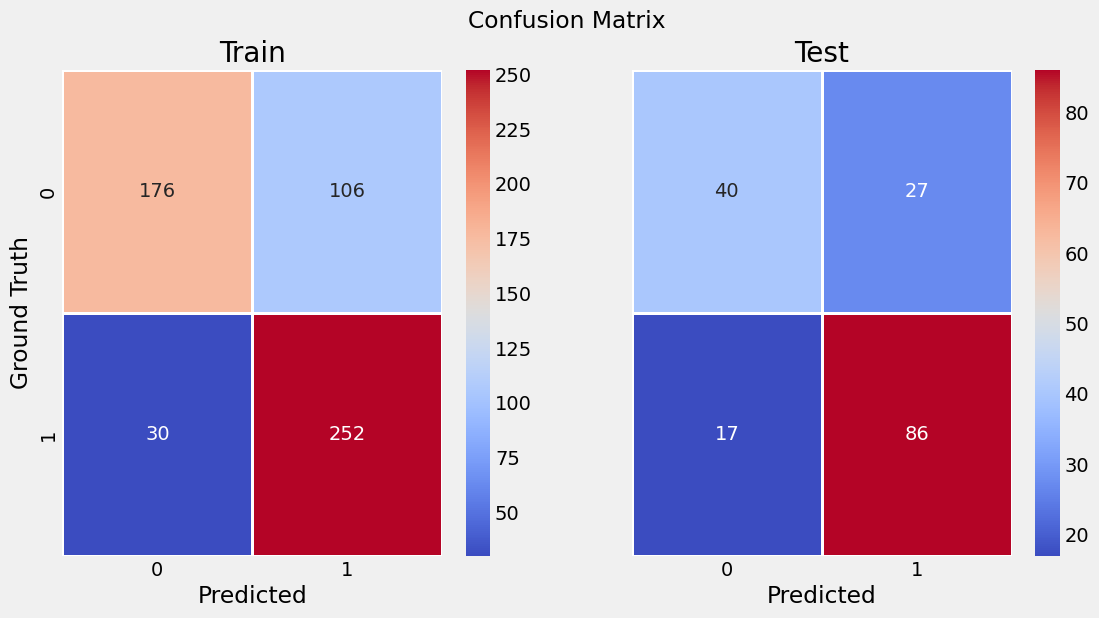

In [ ]:
#Confusion Matrix
fig, ax = plt.subplots(1,2, figsize=(12,6), sharey=True)

sns.heatmap(confusion_matrix_train, ax=ax[0], fmt='.0f', **HeatMapParams)
ax[0].set_title('Train')
ax[0].set_ylabel('Ground Truth')
ax[0].set_xlabel('Predicted')

sns.heatmap(confusion_matrix_test, ax=ax[1], fmt='.0f', **HeatMapParams)
ax[1].set_title('Test')
ax[1].set_xlabel('Predicted')

fig.suptitle('Confusion Matrix')

This is a balanced result between training and testing. Its very important look the `recall` result at the classification report. 
I've perform a few tests without upsampling the labels and rescaling the features, in this scenario the model achive high values of `accuracy` (up to 85%) but poor recall (around 30%). The worse recall occurred for the label 0, which means the model could not "say no" to loan applicants which can lead to high business losses.

In [18]:
[*range(10)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]